In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')

# Define the 2D Rastrigin function
def rastrigin(x):
    """
    Rastrigin function in 2D
    x: array of shape (2,) or (n, 2)
    Returns: function value(s)
    """
    if x.ndim == 1:
        x1, x2 = x[0], x[1]
        return 20 + (x1**2 - 10*np.cos(2*np.pi*x1)) + (x2**2 - 10*np.cos(2*np.pi*x2))
    else:
        x1, x2 = x[:, 0], x[:, 1]
        return 20 + (x1**2 - 10*np.cos(2*np.pi*x1)) + (x2**2 - 10*np.cos(2*np.pi*x2))

# Helper function: Initialize population
def initialize_population(NP, D, bounds):
    """Initialize population uniformly within bounds"""
    lower, upper = bounds
    return np.random.uniform(lower, upper, (NP, D))

# Helper function: Mutation DE/rand/1
def mutation_rand(pop, F, idx):
    """DE/rand/1 mutation: v_i = x_r1 + F * (x_r2 - x_r3)"""
    NP = len(pop)
    candidates = [i for i in range(NP) if i != idx]
    r1, r2, r3 = np.random.choice(candidates, 3, replace=False)
    mutant = pop[r1] + F * (pop[r2] - pop[r3])
    return mutant

# Helper function: Mutation DE/best/1
def mutation_best(pop, F, idx, best_idx):
    """DE/best/1 mutation: v_i = x_best + F * (x_r1 - x_r2)"""
    NP = len(pop)
    candidates = [i for i in range(NP) if i != idx]
    r1, r2 = np.random.choice(candidates, 2, replace=False)
    mutant = pop[best_idx] + F * (pop[r1] - pop[r2])
    return mutant

# Helper function: Binomial crossover
def crossover_bin(target, mutant, CR, D):
    """Binomial crossover"""
    trial = np.copy(target)
    j_rand = np.random.randint(0, D)
    for j in range(D):
        if np.random.rand() < CR or j == j_rand:
            trial[j] = mutant[j]
    return trial

# Helper function: Apply bounds
def apply_bounds(x, bounds):
    """Clip solution to bounds"""
    lower, upper = bounds
    return np.clip(x, lower, upper)

# Helper function: Selection
def selection(target_fit, trial_fit):
    """Return True if trial is better (minimization)"""
    return trial_fit <= target_fit

print("✓ All imports and helper functions defined successfully!")
print(f"✓ Rastrigin function test: f(0,0) = {rastrigin(np.array([0.0, 0.0])):.6f} (should be 0)")
print(f"✓ Rastrigin function test: f(5.12,5.12) = {rastrigin(np.array([5.12, 5.12])):.6f}")


✓ All imports and helper functions defined successfully!
✓ Rastrigin function test: f(0,0) = 0.000000 (should be 0)
✓ Rastrigin function test: f(5.12,5.12) = 57.849427


Running DE/rand/1/bin for 5 seeds...
Seed   1: Best fitness = 0.000000, Solution = [-0.0000, -0.0000]
Seed  11: Best fitness = 0.000000, Solution = [0.0000, -0.0000]
Seed  42: Best fitness = 0.000000, Solution = [-0.0000, -0.0000]
Seed 100: Best fitness = 0.000000, Solution = [-0.0000, 0.0000]
Seed 999: Best fitness = 0.000000, Solution = [-0.0000, -0.0000]


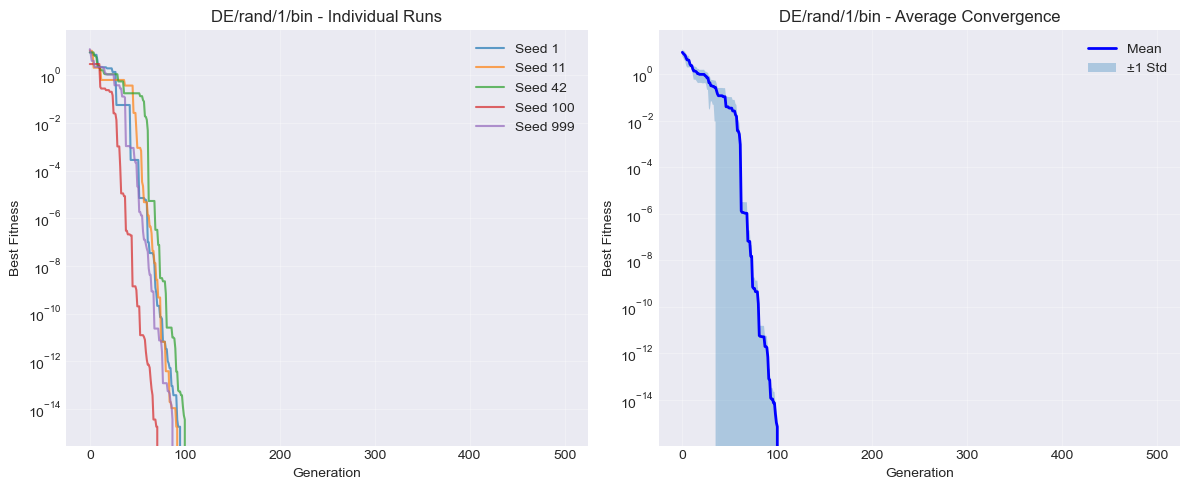


DE/rand/1/bin Summary Statistics:
Mean final fitness:   0.000000
Std final fitness:    0.000000
Min final fitness:    0.000000
Median final fitness: 0.000000
Max final fitness:    0.000000


In [3]:
def DE_rand_1_bin(NP, D, bounds, F, CR, max_evals, seed):
    """Differential Evolution with DE/rand/1/bin strategy"""
    np.random.seed(seed)
    
    # Initialize
    pop = initialize_population(NP, D, bounds)
    fitness = np.array([rastrigin(ind) for ind in pop])
    
    # Track best
    best_idx = np.argmin(fitness)
    best_fitness = fitness[best_idx]
    best_solution = pop[best_idx].copy()
    
    # Convergence tracking
    convergence = [best_fitness]
    evals = NP
    
    # Evolution loop
    while evals < max_evals:
        for i in range(NP):
            # Mutation: DE/rand/1
            mutant = mutation_rand(pop, F, i)
            mutant = apply_bounds(mutant, bounds)
            
            # Crossover: binomial
            trial = crossover_bin(pop[i], mutant, CR, D)
            trial = apply_bounds(trial, bounds)
            
            # Evaluation
            trial_fit = rastrigin(trial)
            evals += 1
            
            # Selection
            if selection(fitness[i], trial_fit):
                pop[i] = trial
                fitness[i] = trial_fit
                
                # Update best
                if trial_fit < best_fitness:
                    best_fitness = trial_fit
                    best_solution = trial.copy()
        
        convergence.append(best_fitness)
        
        if evals >= max_evals:
            break
    
    return {
        'best_fitness': best_fitness,
        'best_solution': best_solution,
        'convergence': convergence,
        'evals': evals
    }

# Parameters
NP = 20
D = 2
bounds = (-5.12, 5.12)
F = 0.5
CR = 0.9
max_evals = 10000
seeds = [1, 11, 42, 100, 999]

# Run DE/rand/1/bin for 5 seeds
print("Running DE/rand/1/bin for 5 seeds...")
results_rand = []
for seed in seeds:
    result = DE_rand_1_bin(NP, D, bounds, F, CR, max_evals, seed)
    results_rand.append(result)
    print(f"Seed {seed:3d}: Best fitness = {result['best_fitness']:.6f}, Solution = [{result['best_solution'][0]:.4f}, {result['best_solution'][1]:.4f}]")

# Plot convergence curves
plt.figure(figsize=(12, 5))

# Individual runs
plt.subplot(1, 2, 1)
for i, (seed, result) in enumerate(zip(seeds, results_rand)):
    plt.plot(result['convergence'], label=f'Seed {seed}', alpha=0.7)
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('DE/rand/1/bin - Individual Runs')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)

# Average convergence
plt.subplot(1, 2, 2)
max_len = max(len(r['convergence']) for r in results_rand)
convergence_matrix = np.full((len(results_rand), max_len), np.nan)
for i, result in enumerate(results_rand):
    conv = result['convergence']
    convergence_matrix[i, :len(conv)] = conv

avg_conv = np.nanmean(convergence_matrix, axis=0)
std_conv = np.nanstd(convergence_matrix, axis=0)
plt.plot(avg_conv, 'b-', linewidth=2, label='Mean')
plt.fill_between(range(len(avg_conv)), 
                 avg_conv - std_conv, 
                 avg_conv + std_conv, 
                 alpha=0.3, label='±1 Std')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('DE/rand/1/bin - Average Convergence')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('de_rand_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary statistics
final_fitness_rand = [r['best_fitness'] for r in results_rand]
print("\n" + "="*60)
print("DE/rand/1/bin Summary Statistics:")
print("="*60)
print(f"Mean final fitness:   {np.mean(final_fitness_rand):.6f}")
print(f"Std final fitness:    {np.std(final_fitness_rand):.6f}")
print(f"Min final fitness:    {np.min(final_fitness_rand):.6f}")
print(f"Median final fitness: {np.median(final_fitness_rand):.6f}")
print(f"Max final fitness:    {np.max(final_fitness_rand):.6f}")
print("="*60)

Running DE/best/1/bin for 5 seeds...
Seed   1: Best fitness = 0.000000, Solution = [0.0000, 0.0000]
Seed  11: Best fitness = 0.994959, Solution = [-0.0000, 0.9950]
Seed  42: Best fitness = 1.989918, Solution = [-0.9950, 0.9950]
Seed 100: Best fitness = 0.994959, Solution = [0.0000, 0.9950]
Seed 999: Best fitness = 0.000000, Solution = [0.0000, -0.0000]


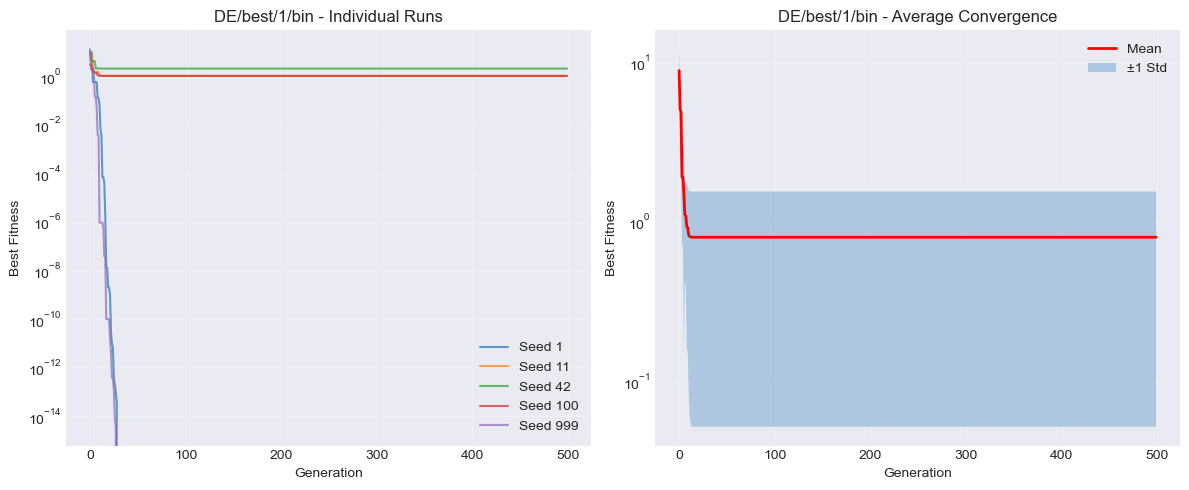


DE/best/1/bin Summary Statistics:
Mean final fitness:   0.795967
Std final fitness:    0.744559
Min final fitness:    0.000000
Median final fitness: 0.994959
Max final fitness:    1.989918


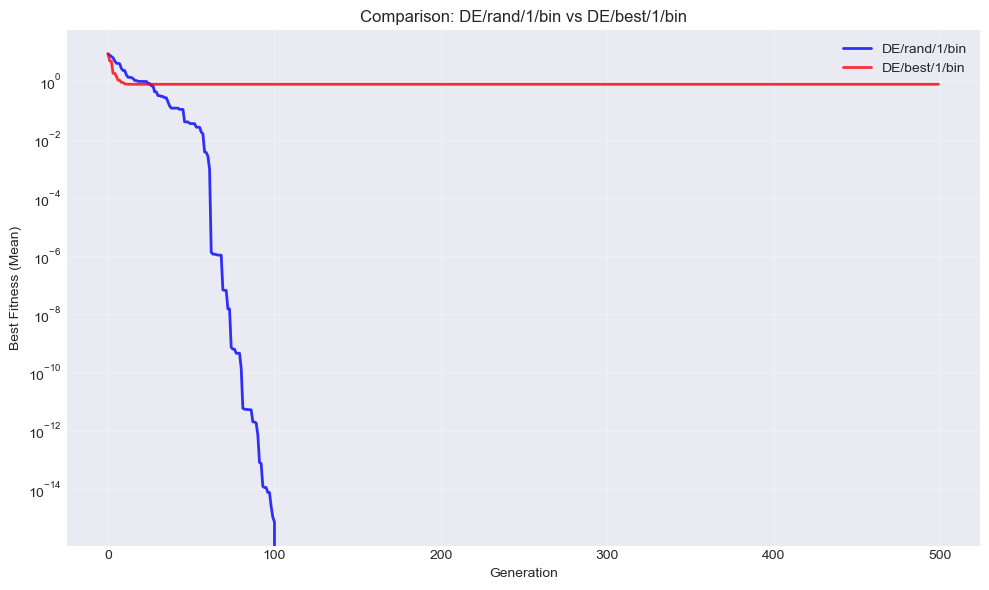


Comparison: DE/rand/1/bin vs DE/best/1/bin
DE/rand/1/bin - Mean: 0.000000
DE/best/1/bin - Mean: 0.795967
→ DE/rand/1/bin performs better on average!


In [5]:
def DE_best_1_bin(NP, D, bounds, F, CR, max_evals, seed):
    """Differential Evolution with DE/best/1/bin strategy"""
    np.random.seed(seed)
    
    # Initialize
    pop = initialize_population(NP, D, bounds)
    fitness = np.array([rastrigin(ind) for ind in pop])
    
    # Track best
    best_idx = np.argmin(fitness)
    best_fitness = fitness[best_idx]
    best_solution = pop[best_idx].copy()
    
    # Convergence tracking
    convergence = [best_fitness]
    evals = NP
    
    # Evolution loop
    while evals < max_evals:
        for i in range(NP):
            # Mutation: DE/best/1
            mutant = mutation_best(pop, F, i, best_idx)
            mutant = apply_bounds(mutant, bounds)
            
            # Crossover: binomial
            trial = crossover_bin(pop[i], mutant, CR, D)
            trial = apply_bounds(trial, bounds)
            
            # Evaluation
            trial_fit = rastrigin(trial)
            evals += 1
            
            # Selection
            if selection(fitness[i], trial_fit):
                pop[i] = trial
                fitness[i] = trial_fit
                
                # Update best
                if trial_fit < best_fitness:
                    best_fitness = trial_fit
                    best_solution = trial.copy()
                    best_idx = i
        
        convergence.append(best_fitness)
        
        if evals >= max_evals:
            break
    
    return {
        'best_fitness': best_fitness,
        'best_solution': best_solution,
        'convergence': convergence,
        'evals': evals
    }

# Run DE/best/1/bin for 5 seeds
print("Running DE/best/1/bin for 5 seeds...")
results_best = []
for seed in seeds:
    result = DE_best_1_bin(NP, D, bounds, F, CR, max_evals, seed)
    results_best.append(result)
    print(f"Seed {seed:3d}: Best fitness = {result['best_fitness']:.6f}, Solution = [{result['best_solution'][0]:.4f}, {result['best_solution'][1]:.4f}]")

# Plot convergence curves
plt.figure(figsize=(12, 5))

# Individual runs
plt.subplot(1, 2, 1)
for i, (seed, result) in enumerate(zip(seeds, results_best)):
    plt.plot(result['convergence'], label=f'Seed {seed}', alpha=0.7)
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('DE/best/1/bin - Individual Runs')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)

# Average convergence
plt.subplot(1, 2, 2)
max_len = max(len(r['convergence']) for r in results_best)
convergence_matrix = np.full((len(results_best), max_len), np.nan)
for i, result in enumerate(results_best):
    conv = result['convergence']
    convergence_matrix[i, :len(conv)] = conv

avg_conv = np.nanmean(convergence_matrix, axis=0)
std_conv = np.nanstd(convergence_matrix, axis=0)
plt.plot(avg_conv, 'r-', linewidth=2, label='Mean')
plt.fill_between(range(len(avg_conv)), 
                 avg_conv - std_conv, 
                 avg_conv + std_conv, 
                 alpha=0.3, label='±1 Std')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('DE/best/1/bin - Average Convergence')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('de_best_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary statistics
final_fitness_best = [r['best_fitness'] for r in results_best]
print("\n" + "="*60)
print("DE/best/1/bin Summary Statistics:")
print("="*60)
print(f"Mean final fitness:   {np.mean(final_fitness_best):.6f}")
print(f"Std final fitness:    {np.std(final_fitness_best):.6f}")
print(f"Min final fitness:    {np.min(final_fitness_best):.6f}")
print(f"Median final fitness: {np.median(final_fitness_best):.6f}")
print(f"Max final fitness:    {np.max(final_fitness_best):.6f}")
print("="*60)

# Comparison plot
plt.figure(figsize=(10, 6))
max_len_rand = max(len(r['convergence']) for r in results_rand)
max_len_best = max(len(r['convergence']) for r in results_best)
max_len = max(max_len_rand, max_len_best)

# Compute averages
conv_rand = np.full((len(results_rand), max_len), np.nan)
for i, result in enumerate(results_rand):
    conv_rand[i, :len(result['convergence'])] = result['convergence']
avg_rand = np.nanmean(conv_rand, axis=0)

conv_best = np.full((len(results_best), max_len), np.nan)
for i, result in enumerate(results_best):
    conv_best[i, :len(result['convergence'])] = result['convergence']
avg_best = np.nanmean(conv_best, axis=0)

plt.plot(avg_rand, 'b-', linewidth=2, label='DE/rand/1/bin', alpha=0.8)
plt.plot(avg_best, 'r-', linewidth=2, label='DE/best/1/bin', alpha=0.8)
plt.xlabel('Generation')
plt.ylabel('Best Fitness (Mean)')
plt.title('Comparison: DE/rand/1/bin vs DE/best/1/bin')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('de_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("Comparison: DE/rand/1/bin vs DE/best/1/bin")
print("="*60)
print(f"DE/rand/1/bin - Mean: {np.mean(final_fitness_rand):.6f}")
print(f"DE/best/1/bin - Mean: {np.mean(final_fitness_best):.6f}")
if np.mean(final_fitness_best) < np.mean(final_fitness_rand):
    print("→ DE/best/1/bin performs better on average!")
    better_variant = 'best'
else:
    print("→ DE/rand/1/bin performs better on average!")
    better_variant = 'rand'
print("="*60)

Using DE/rand/1/bin for F experiments

Running experiments with different F values...

Testing F = 0.4
  Seed   1: Best fitness = 0.000000
  Seed  11: Best fitness = 0.041534
  Seed  42: Best fitness = 0.000000
  Seed 100: Best fitness = 0.000000
  Seed 999: Best fitness = 0.000000

Testing F = 0.6
  Seed   1: Best fitness = 0.000000
  Seed  11: Best fitness = 0.000000
  Seed  42: Best fitness = 0.000000
  Seed 100: Best fitness = 0.000000
  Seed 999: Best fitness = 0.000000

Testing F = 0.8
  Seed   1: Best fitness = 0.000000
  Seed  11: Best fitness = 0.000000
  Seed  42: Best fitness = 0.000000
  Seed 100: Best fitness = 0.000000
  Seed 999: Best fitness = 0.000000

Testing F = 1.0
  Seed   1: Best fitness = 0.000000
  Seed  11: Best fitness = 0.000000
  Seed  42: Best fitness = 0.000000
  Seed 100: Best fitness = 0.000000
  Seed 999: Best fitness = 0.000000


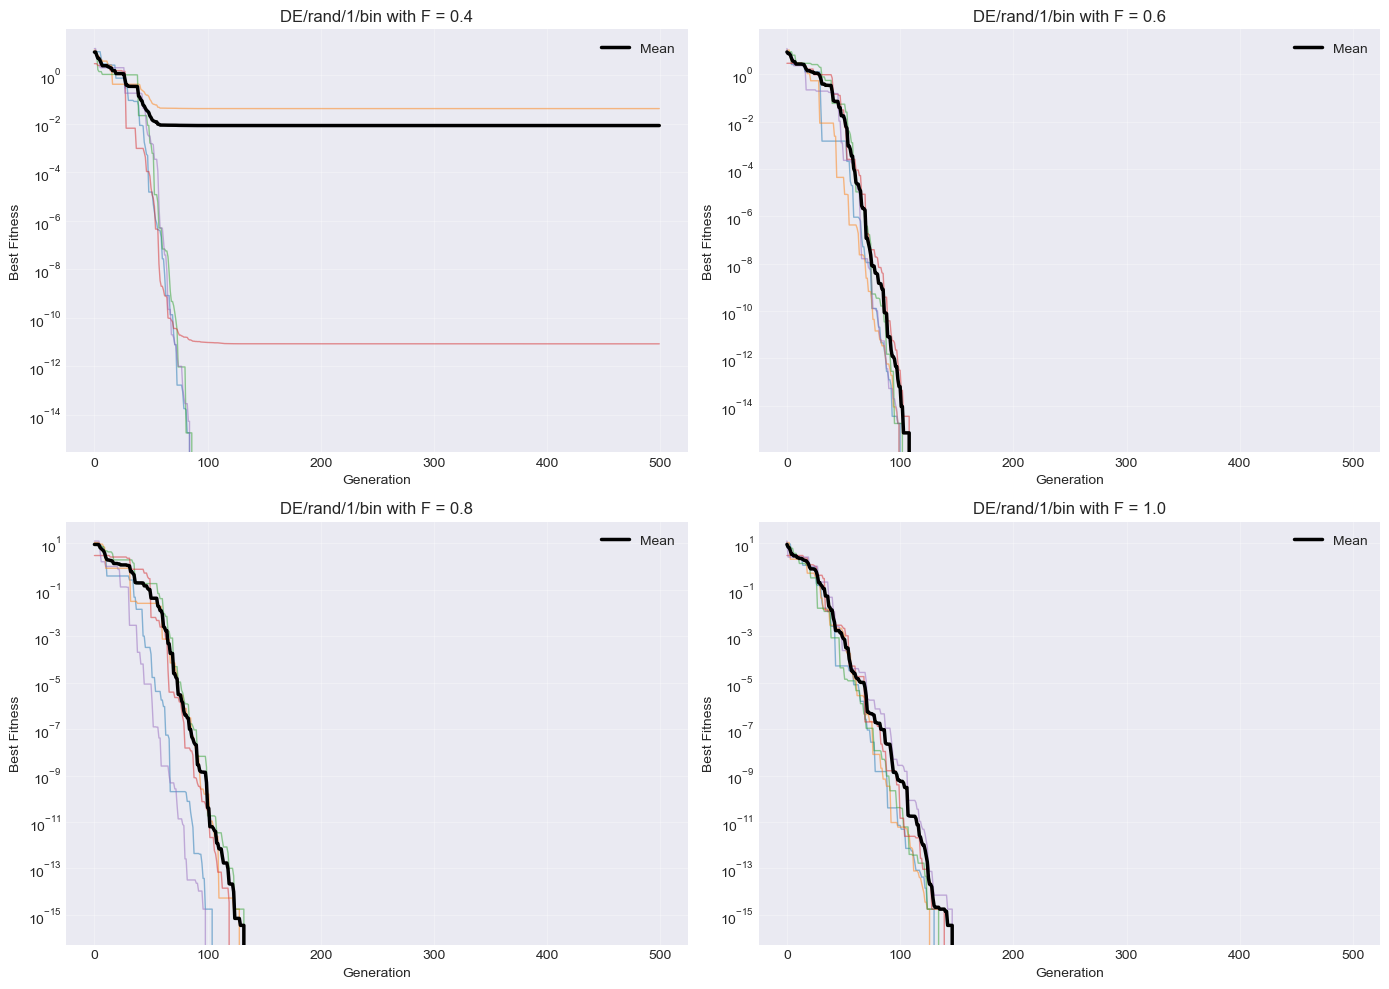

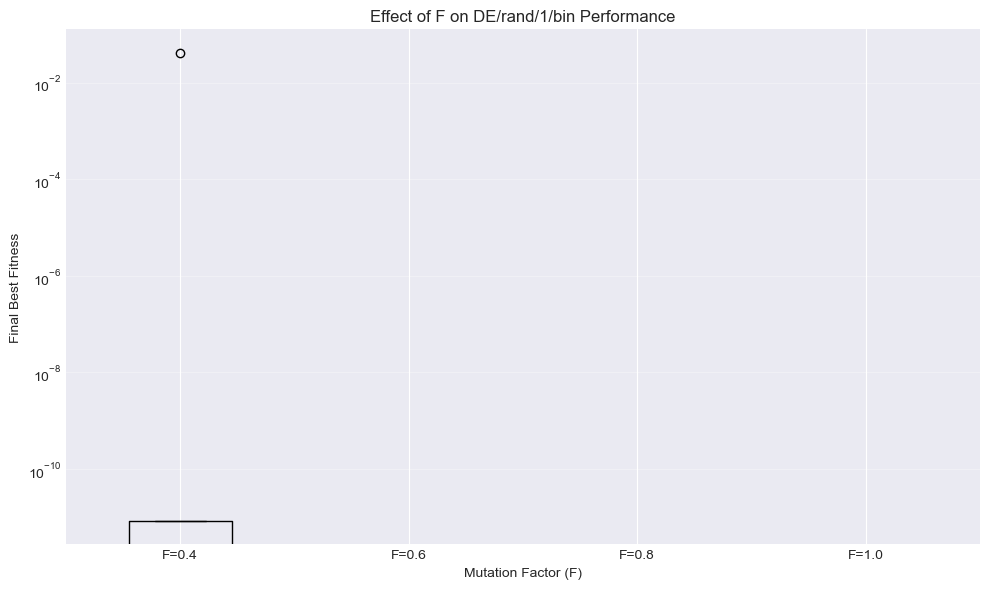


Summary: Effect of F on DE/rand/1/bin
F Value    Mean         Std          Min          Median       Max         
--------------------------------------------------------------------------------
0.4        0.008307     0.016614     0.000000     0.000000     0.041534    
0.6        0.000000     0.000000     0.000000     0.000000     0.000000    
0.8        0.000000     0.000000     0.000000     0.000000     0.000000    
1.0        0.000000     0.000000     0.000000     0.000000     0.000000    

→ Best performing F: 0.6 (mean fitness: 0.000000)


In [9]:
# Determine which variant to use
if better_variant == 'best':
    DE_function = DE_best_1_bin
    variant_name = 'DE/best/1/bin'
else:
    DE_function = DE_rand_1_bin
    variant_name = 'DE/rand/1/bin'

print(f"Using {variant_name} for F experiments\n")

# F values to test
F_values = [0.4, 0.6, 0.8, 1.0]
results_F = {F: [] for F in F_values}

print("Running experiments with different F values...")
for F_val in F_values:
    print(f"\nTesting F = {F_val}")
    for seed in seeds:
        result = DE_function(NP, D, bounds, F_val, CR, max_evals, seed)
        results_F[F_val].append(result)
        print(f"  Seed {seed:3d}: Best fitness = {result['best_fitness']:.6f}")

# Plot convergence curves for all F values
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, F_val in enumerate(F_values):
    ax = axes[idx]
    for seed, result in zip(seeds, results_F[F_val]):
        ax.plot(result['convergence'], alpha=0.5, linewidth=1)
    
    # Average
    max_len = max(len(r['convergence']) for r in results_F[F_val])
    conv_matrix = np.full((len(results_F[F_val]), max_len), np.nan)
    for i, result in enumerate(results_F[F_val]):
        conv_matrix[i, :len(result['convergence'])] = result['convergence']
    avg_conv = np.nanmean(conv_matrix, axis=0)
    ax.plot(avg_conv, 'k-', linewidth=2.5, label='Mean')
    
    ax.set_xlabel('Generation')
    ax.set_ylabel('Best Fitness')
    ax.set_title(f'{variant_name} with F = {F_val}')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.savefig('f_values_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

# Boxplot comparison
final_fitness_F = {F: [r['best_fitness'] for r in results_F[F]] for F in F_values}

plt.figure(figsize=(10, 6))
plt.boxplot([final_fitness_F[F] for F in F_values], 
            labels=[f'F={F}' for F in F_values])
plt.ylabel('Final Best Fitness')
plt.xlabel('Mutation Factor (F)')
plt.title(f'Effect of F on {variant_name} Performance')
plt.grid(True, alpha=0.3, axis='y')
plt.yscale('log')
plt.tight_layout()
plt.savefig('f_values_boxplot.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary table
print("\n" + "="*80)
print(f"Summary: Effect of F on {variant_name}")
print("="*80)
print(f"{'F Value':<10} {'Mean':<12} {'Std':<12} {'Min':<12} {'Median':<12} {'Max':<12}")
print("-"*80)
for F_val in F_values:
    fits = final_fitness_F[F_val]
    print(f"{F_val:<10.1f} {np.mean(fits):<12.6f} {np.std(fits):<12.6f} {np.min(fits):<12.6f} {np.median(fits):<12.6f} {np.max(fits):<12.6f}")
print("="*80)

# Find best F
best_F = min(F_values, key=lambda f: np.mean(final_fitness_F[f]))
print(f"\n→ Best performing F: {best_F} (mean fitness: {np.mean(final_fitness_F[best_F]):.6f})")
print("="*80)


Using DE/rand/1/bin with F = 0.6 for CR experiments

Running experiments with different CR values...

Testing CR = 0.1
  Seed   1: Best fitness = 0.000000
  Seed  11: Best fitness = 0.000000
  Seed  42: Best fitness = 0.000000
  Seed 100: Best fitness = 0.000000
  Seed 999: Best fitness = 0.000000

Testing CR = 0.3
  Seed   1: Best fitness = 0.000000
  Seed  11: Best fitness = 0.000000
  Seed  42: Best fitness = 0.000000
  Seed 100: Best fitness = 0.000000
  Seed 999: Best fitness = 0.000000

Testing CR = 0.5
  Seed   1: Best fitness = 0.000000
  Seed  11: Best fitness = 0.000000
  Seed  42: Best fitness = 0.000000
  Seed 100: Best fitness = 0.000000
  Seed 999: Best fitness = 0.000000

Testing CR = 0.9
  Seed   1: Best fitness = 0.000000
  Seed  11: Best fitness = 0.000000
  Seed  42: Best fitness = 0.000000
  Seed 100: Best fitness = 0.000000
  Seed 999: Best fitness = 0.000000


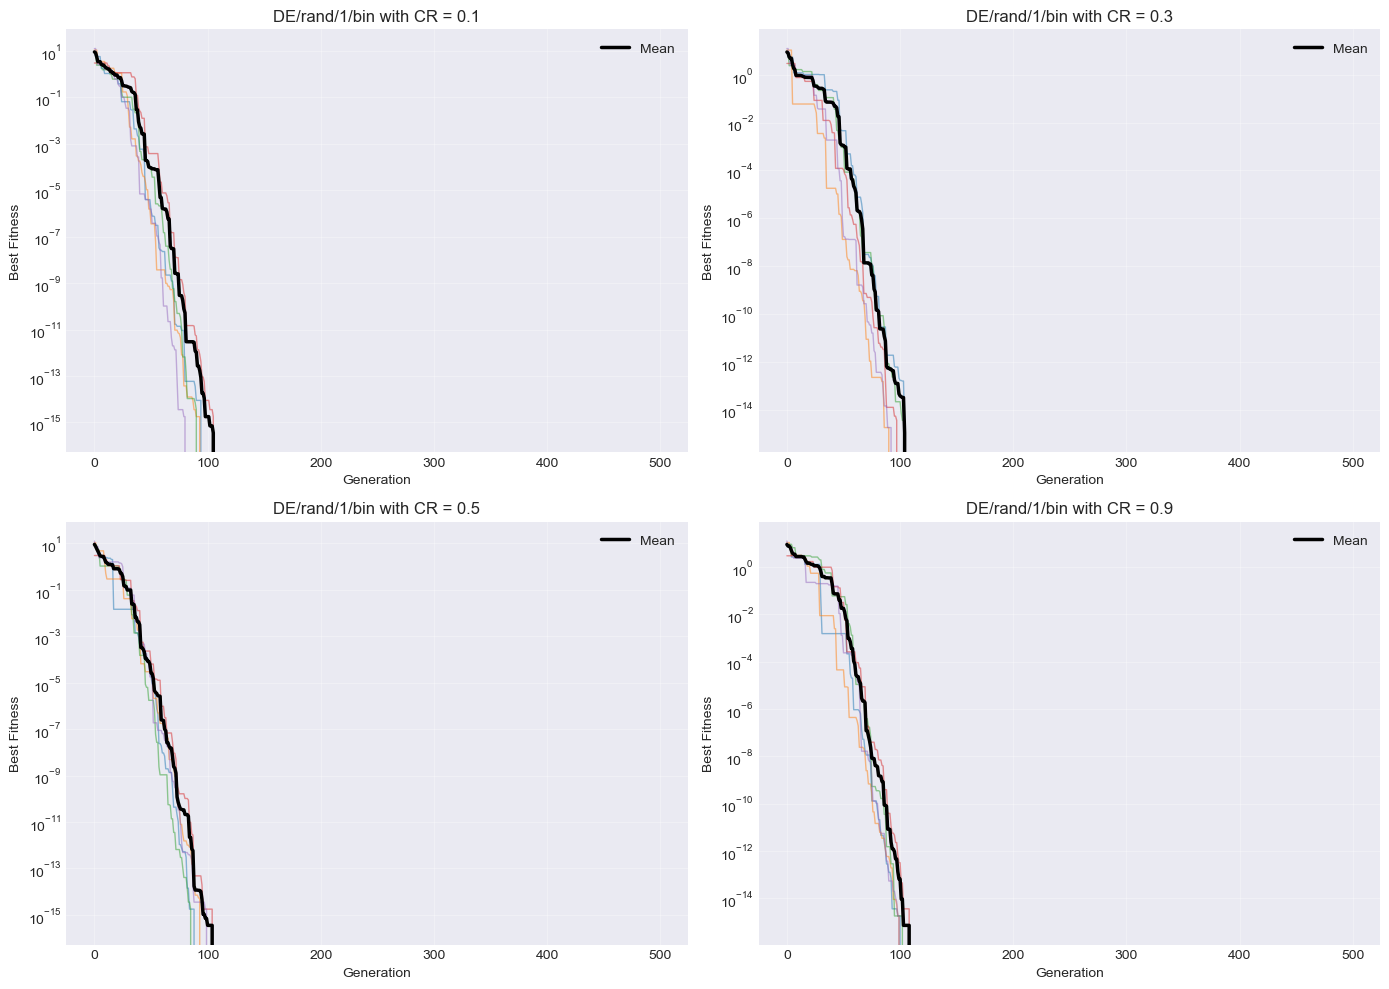

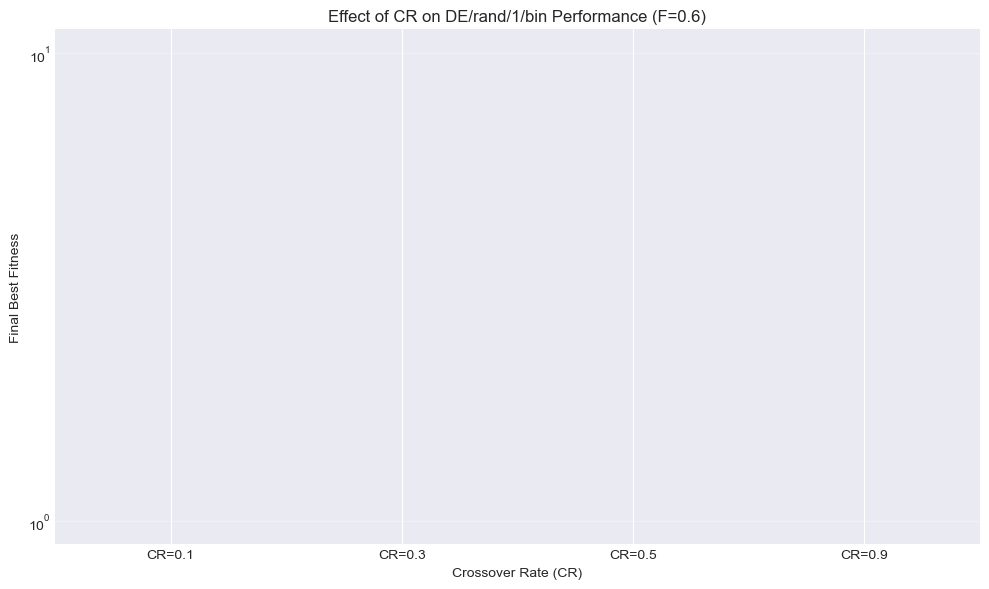


Summary: Effect of CR on DE/rand/1/bin (F=0.6)
CR Value   Mean         Std          Min          Median       Max         
--------------------------------------------------------------------------------
0.1        0.000000     0.000000     0.000000     0.000000     0.000000    
0.3        0.000000     0.000000     0.000000     0.000000     0.000000    
0.5        0.000000     0.000000     0.000000     0.000000     0.000000    
0.9        0.000000     0.000000     0.000000     0.000000     0.000000    

→ Best performing CR: 0.1 (mean fitness: 0.000000)


In [11]:

try:
    variant_name
    best_F
    DE_function
except NameError:
    print("WARNING: Cell 4 variables not found. Using defaults from Cell 3.")
    # Determine which variant to use based on Cell 3 results
    if np.mean(final_fitness_best) < np.mean(final_fitness_rand):
        DE_function = DE_best_1_bin
        variant_name = 'DE/best/1/bin'
        better_variant = 'best'
    else:
        DE_function = DE_rand_1_bin
        variant_name = 'DE/rand/1/bin'
        better_variant = 'rand'
    
    # Need to determine best_F from a quick check
    # For now, use F=0.5 as default
    best_F = 0.5
    print(f"Using {variant_name} with default F = {best_F}")

# CR values to test
CR_values = [0.1, 0.3, 0.5, 0.9]
results_CR = {CR: [] for CR in CR_values}

print(f"\nUsing {variant_name} with F = {best_F} for CR experiments\n")
print("Running experiments with different CR values...")

for CR_val in CR_values:
    print(f"\nTesting CR = {CR_val}")
    for seed in seeds:
        result = DE_function(NP, D, bounds, best_F, CR_val, max_evals, seed)
        results_CR[CR_val].append(result)
        print(f"  Seed {seed:3d}: Best fitness = {result['best_fitness']:.6f}")

# Plot convergence curves for all CR values
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, CR_val in enumerate(CR_values):
    ax = axes[idx]
    for seed, result in zip(seeds, results_CR[CR_val]):
        ax.plot(result['convergence'], alpha=0.5, linewidth=1)
    
    # Average
    max_len = max(len(r['convergence']) for r in results_CR[CR_val])
    conv_matrix = np.full((len(results_CR[CR_val]), max_len), np.nan)
    for i, result in enumerate(results_CR[CR_val]):
        conv_matrix[i, :len(result['convergence'])] = result['convergence']
    avg_conv = np.nanmean(conv_matrix, axis=0)
    ax.plot(avg_conv, 'k-', linewidth=2.5, label='Mean')
    
    ax.set_xlabel('Generation')
    ax.set_ylabel('Best Fitness')
    ax.set_title(f'{variant_name} with CR = {CR_val}')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.savefig('cr_values_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

# Boxplot comparison
final_fitness_CR = {CR: [r['best_fitness'] for r in results_CR[CR]] for CR in CR_values}

plt.figure(figsize=(10, 6))
plt.boxplot([final_fitness_CR[CR] for CR in CR_values], 
            labels=[f'CR={CR}' for CR in CR_values])
plt.ylabel('Final Best Fitness')
plt.xlabel('Crossover Rate (CR)')
plt.title(f'Effect of CR on {variant_name} Performance (F={best_F})')
plt.grid(True, alpha=0.3, axis='y')
plt.yscale('log')
plt.tight_layout()
plt.savefig('cr_values_boxplot.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary table
print("\n" + "="*80)
print(f"Summary: Effect of CR on {variant_name} (F={best_F})")
print("="*80)
print(f"{'CR Value':<10} {'Mean':<12} {'Std':<12} {'Min':<12} {'Median':<12} {'Max':<12}")
print("-"*80)
for CR_val in CR_values:
    fits = final_fitness_CR[CR_val]
    print(f"{CR_val:<10.1f} {np.mean(fits):<12.6f} {np.std(fits):<12.6f} {np.min(fits):<12.6f} {np.median(fits):<12.6f} {np.max(fits):<12.6f}")
print("="*80)

# Find best CR
best_CR = min(CR_values, key=lambda cr: np.mean(final_fitness_CR[cr]))
print(f"\n→ Best performing CR: {best_CR} (mean fitness: {np.mean(final_fitness_CR[best_CR]):.6f})")
print("="*80)

Using DE/rand/1/bin with Random F ~ Uniform(0.5, 1.0) and CR = 0.1

Running experiments with random F per generation...
Seed   1: Best fitness = 0.000000, Solution = [0.0000, -0.0000]
Seed  11: Best fitness = 0.000000, Solution = [0.0000, 0.0000]
Seed  42: Best fitness = 0.000000, Solution = [0.0000, -0.0000]
Seed 100: Best fitness = 0.000000, Solution = [0.0000, 0.0000]
Seed 999: Best fitness = 0.000000, Solution = [0.0000, 0.0000]


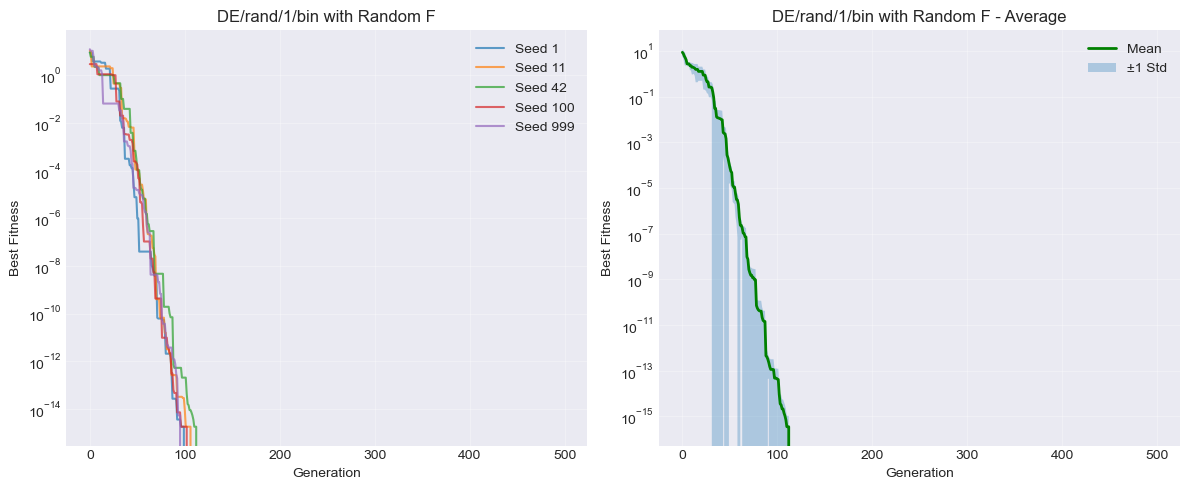


DE/rand/1/bin with Random F Summary:
Mean final fitness:   0.000000
Std final fitness:    0.000000
Min final fitness:    0.000000
Median final fitness: 0.000000
Max final fitness:    0.000000


In [13]:
def DE_random_F(NP, D, bounds, F_range, CR, max_evals, seed, variant='best'):
    """Differential Evolution with random F per generation"""
    np.random.seed(seed)
    
    # Initialize
    pop = initialize_population(NP, D, bounds)
    fitness = np.array([rastrigin(ind) for ind in pop])
    
    # Track best
    best_idx = np.argmin(fitness)
    best_fitness = fitness[best_idx]
    best_solution = pop[best_idx].copy()
    
    # Convergence tracking
    convergence = [best_fitness]
    evals = NP
    
    F_min, F_max = F_range
    
    # Evolution loop
    while evals < max_evals:
        # Draw random F for this generation
        F = np.random.uniform(F_min, F_max)
        
        for i in range(NP):
            # Mutation
            if variant == 'best':
                mutant = mutation_best(pop, F, i, best_idx)
            else:
                mutant = mutation_rand(pop, F, i)
            mutant = apply_bounds(mutant, bounds)
            
            # Crossover: binomial
            trial = crossover_bin(pop[i], mutant, CR, D)
            trial = apply_bounds(trial, bounds)
            
            # Evaluation
            trial_fit = rastrigin(trial)
            evals += 1
            
            # Selection
            if selection(fitness[i], trial_fit):
                pop[i] = trial
                fitness[i] = trial_fit
                
                # Update best
                if trial_fit < best_fitness:
                    best_fitness = trial_fit
                    best_solution = trial.copy()
                    if variant == 'best':
                        best_idx = i
        
        convergence.append(best_fitness)
        
        if evals >= max_evals:
            break
    
    return {
        'best_fitness': best_fitness,
        'best_solution': best_solution,
        'convergence': convergence,
        'evals': evals
    }

# Parameters
F_range = (0.5, 1.0)
print(f"Using {variant_name} with Random F ~ Uniform{F_range} and CR = {best_CR}\n")
print("Running experiments with random F per generation...")

results_random_F = []
for seed in seeds:
    result = DE_random_F(NP, D, bounds, F_range, best_CR, max_evals, seed, variant=better_variant)
    results_random_F.append(result)
    print(f"Seed {seed:3d}: Best fitness = {result['best_fitness']:.6f}, Solution = [{result['best_solution'][0]:.4f}, {result['best_solution'][1]:.4f}]")

# Plot convergence
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for seed, result in zip(seeds, results_random_F):
    plt.plot(result['convergence'], label=f'Seed {seed}', alpha=0.7)
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title(f'{variant_name} with Random F')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
max_len = max(len(r['convergence']) for r in results_random_F)
conv_matrix = np.full((len(results_random_F), max_len), np.nan)
for i, result in enumerate(results_random_F):
    conv_matrix[i, :len(result['convergence'])] = result['convergence']

avg_conv = np.nanmean(conv_matrix, axis=0)
std_conv = np.nanstd(conv_matrix, axis=0)
plt.plot(avg_conv, 'g-', linewidth=2, label='Mean')
plt.fill_between(range(len(avg_conv)), 
                 avg_conv - std_conv, 
                 avg_conv + std_conv, 
                 alpha=0.3, label='±1 Std')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title(f'{variant_name} with Random F - Average')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('random_f_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary statistics
final_fitness_random_F = [r['best_fitness'] for r in results_random_F]
print("\n" + "="*60)
print(f"{variant_name} with Random F Summary:")
print("="*60)
print(f"Mean final fitness:   {np.mean(final_fitness_random_F):.6f}")
print(f"Std final fitness:    {np.std(final_fitness_random_F):.6f}")
print(f"Min final fitness:    {np.min(final_fitness_random_F):.6f}")
print(f"Median final fitness: {np.median(final_fitness_random_F):.6f}")
print(f"Max final fitness:    {np.max(final_fitness_random_F):.6f}")
print("="*60)

Statistical Analysis: Wilcoxon Signed-Rank Test

Top 2 Performing Configurations:
1. DE/rand/1/bin (F=0.5, CR=0.9)
   Mean fitness: 0.000000

2. DE/rand/1/bin (F=0.6, CR=0.9)
   Mean fitness: 0.000000

--------------------------------------------------------------------------------
Wilcoxon Signed-Rank Test Results:
--------------------------------------------------------------------------------
NOTE: Both configurations produced IDENTICAL results across all runs.
Statistical test cannot be performed (no differences to test).

Conclusion: Both configurations perform EQUALLY WELL.
             All runs converged to the same fitness values.
Test statistic: 0
P-value: 1.000000 (equal performance)


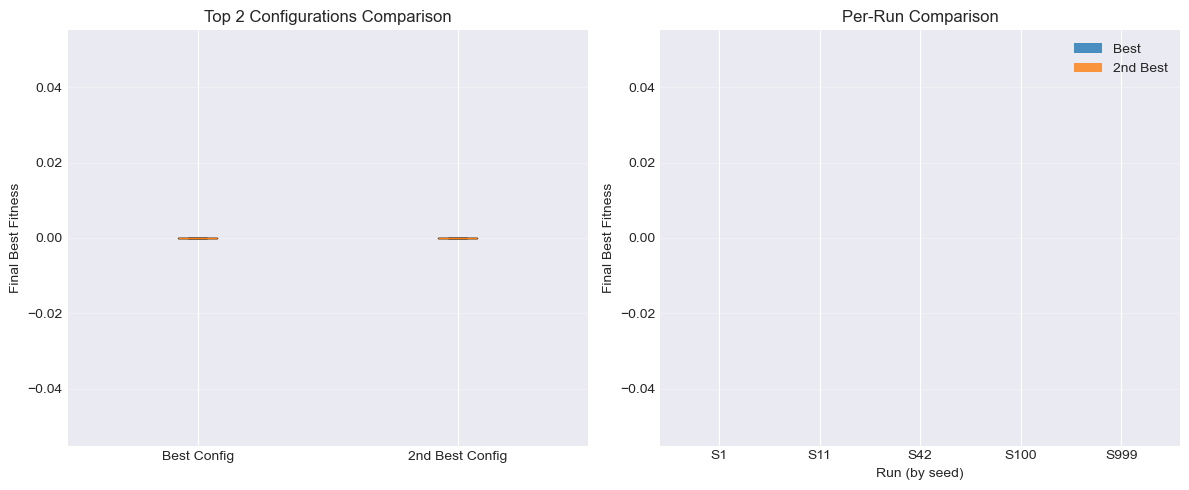


Additional Pairwise Comparisons (Top 5 vs Each Other):
ns p=1.0000 (identical): DE/rand/1/bin (F=0.5, CR=0.9)            vs DE/rand/1/bin (F=0.6, CR=0.9)           
ns p=1.0000 (identical): DE/rand/1/bin (F=0.5, CR=0.9)            vs DE/rand/1/bin (F=0.8, CR=0.9)           
ns p=1.0000 (identical): DE/rand/1/bin (F=0.5, CR=0.9)            vs DE/rand/1/bin (F=1.0, CR=0.9)           
ns p=1.0000 (identical): DE/rand/1/bin (F=0.5, CR=0.9)            vs DE/rand/1/bin (F=0.6, CR=0.1)           
ns p=1.0000 (identical): DE/rand/1/bin (F=0.6, CR=0.9)            vs DE/rand/1/bin (F=0.8, CR=0.9)           
ns p=1.0000 (identical): DE/rand/1/bin (F=0.6, CR=0.9)            vs DE/rand/1/bin (F=1.0, CR=0.9)           
ns p=1.0000 (identical): DE/rand/1/bin (F=0.6, CR=0.9)            vs DE/rand/1/bin (F=0.6, CR=0.1)           
ns p=1.0000 (identical): DE/rand/1/bin (F=0.8, CR=0.9)            vs DE/rand/1/bin (F=1.0, CR=0.9)           
ns p=1.0000 (identical): DE/rand/1/bin (F=0.8, CR=0.9)          

In [19]:


# Collect all configurations and their results
all_configs = []

# Original variants
all_configs.append({
    'name': 'DE/rand/1/bin (F=0.5, CR=0.9)',
    'fitness': final_fitness_rand
})
all_configs.append({
    'name': 'DE/best/1/bin (F=0.5, CR=0.9)',
    'fitness': final_fitness_best
})

# F experiments
for F_val in F_values:
    all_configs.append({
        'name': f'{variant_name} (F={F_val}, CR=0.9)',
        'fitness': final_fitness_F[F_val]
    })

# CR experiments
for CR_val in CR_values:
    all_configs.append({
        'name': f'{variant_name} (F={best_F}, CR={CR_val})',
        'fitness': final_fitness_CR[CR_val]
    })

# Random F
all_configs.append({
    'name': f'{variant_name} (Random F, CR={best_CR})',
    'fitness': final_fitness_random_F
})

# Find top 2 performing configurations
config_means = [(i, np.mean(cfg['fitness'])) for i, cfg in enumerate(all_configs)]
config_means.sort(key=lambda x: x[1])
top2_indices = [config_means[0][0], config_means[1][0]]

print("="*80)
print("Statistical Analysis: Wilcoxon Signed-Rank Test")
print("="*80)
print("\nTop 2 Performing Configurations:")
print(f"1. {all_configs[top2_indices[0]]['name']}")
print(f"   Mean fitness: {np.mean(all_configs[top2_indices[0]]['fitness']):.6f}")
print(f"\n2. {all_configs[top2_indices[1]]['name']}")
print(f"   Mean fitness: {np.mean(all_configs[top2_indices[1]]['fitness']):.6f}")

# Perform Wilcoxon signed-rank test
fitness1 = np.array(all_configs[top2_indices[0]]['fitness'])
fitness2 = np.array(all_configs[top2_indices[1]]['fitness'])

print("\n" + "-"*80)
print("Wilcoxon Signed-Rank Test Results:")
print("-"*80)

# Check if the two samples are identical or have no differences
differences = fitness1 - fitness2
non_zero_diffs = differences[differences != 0]

if len(non_zero_diffs) == 0:
    print("NOTE: Both configurations produced IDENTICAL results across all runs.")
    print("Statistical test cannot be performed (no differences to test).")
    print("\nConclusion: Both configurations perform EQUALLY WELL.")
    print("             All runs converged to the same fitness values.")
    p_value = 1.0  # Set p-value to 1.0 (no difference)
    statistic = 0
    print(f"Test statistic: {statistic}")
    print(f"P-value: {p_value:.6f} (equal performance)")
elif len(non_zero_diffs) < 3:
    print(f"NOTE: Only {len(non_zero_diffs)} run(s) show differences between configurations.")
    print("Sample size too small for reliable Wilcoxon test.")
    print("\nUsing simple comparison:")
    print(f"Configuration 1 mean: {np.mean(fitness1):.8f}")
    print(f"Configuration 2 mean: {np.mean(fitness2):.8f}")
    print(f"Difference: {abs(np.mean(fitness1) - np.mean(fitness2)):.8f}")
    
    if np.mean(fitness1) < np.mean(fitness2):
        print("\nConclusion: Configuration 1 performs slightly better, but difference is minimal.")
    elif np.mean(fitness1) > np.mean(fitness2):
        print("\nConclusion: Configuration 2 performs slightly better, but difference is minimal.")
    else:
        print("\nConclusion: Configurations perform IDENTICALLY.")
    p_value = 0.5  # Inconclusive
else:
    # Perform Wilcoxon signed-rank test (paired samples)
    try:
        statistic, p_value = stats.wilcoxon(fitness1, fitness2, alternative='less')
        
        print(f"Test statistic: {statistic}")
        print(f"P-value: {p_value:.6f}")
        print(f"Significance level (α): 0.05")
        print("-"*80)
        
        if p_value < 0.05:
            print(f"\n✓ SIGNIFICANT DIFFERENCE (p < 0.05)")
            print(f"  {all_configs[top2_indices[0]]['name']}")
            print(f"  performs significantly BETTER than")
            print(f"  {all_configs[top2_indices[1]]['name']}")
        else:
            print(f"\n✗ NO SIGNIFICANT DIFFERENCE (p ≥ 0.05)")
            print(f"  Both configurations perform similarly.")
    except ValueError as e:
        print(f"WARNING: Wilcoxon test failed: {e}")
        print("Using simple comparison instead.")
        print(f"\nConfiguration 1 mean: {np.mean(fitness1):.8f}")
        print(f"Configuration 2 mean: {np.mean(fitness2):.8f}")
        p_value = 1.0

print("="*80)

# Visualize top 2 configurations
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
bp = plt.boxplot([fitness1, fitness2], 
                  labels=['Best Config', '2nd Best Config'])
plt.ylabel('Final Best Fitness')
plt.title('Top 2 Configurations Comparison')
# Only use log scale if values are not all the same
if np.std(fitness1) > 1e-10 or np.std(fitness2) > 1e-10:
    plt.yscale('log')
plt.grid(True, alpha=0.3, axis='y')

plt.subplot(1, 2, 2)
x = np.arange(len(seeds))
width = 0.35
plt.bar(x - width/2, fitness1, width, label='Best', alpha=0.8)
plt.bar(x + width/2, fitness2, width, label='2nd Best', alpha=0.8)
plt.xlabel('Run (by seed)')
plt.ylabel('Final Best Fitness')
plt.title('Per-Run Comparison')
plt.xticks(x, [f'S{s}' for s in seeds])
plt.legend()
# Only use log scale if values vary
if np.std(fitness1) > 1e-10 or np.std(fitness2) > 1e-10:
    plt.yscale('log')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('statistical_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Additional pairwise comparisons
print("\n" + "="*80)
print("Additional Pairwise Comparisons (Top 5 vs Each Other):")
print("="*80)
top5_indices = [config_means[i][0] for i in range(min(5, len(config_means)))]

comparison_results = []
for i in range(len(top5_indices)):
    for j in range(i+1, len(top5_indices)):
        idx1, idx2 = top5_indices[i], top5_indices[j]
        f1 = np.array(all_configs[idx1]['fitness'])
        f2 = np.array(all_configs[idx2]['fitness'])
        
        # Check if samples are different
        if np.array_equal(f1, f2):
            pval = 1.0
            sig = False
            note = " (identical)"
        else:
            try:
                _, pval = stats.wilcoxon(f1, f2, alternative='two-sided')
                sig = pval < 0.05
                note = ""
            except ValueError:
                # If test fails, compare means
                pval = 1.0 if np.mean(f1) == np.mean(f2) else 0.5
                sig = False
                note = " (comparison only)"
        
        comparison_results.append({
            'config1': all_configs[idx1]['name'],
            'config2': all_configs[idx2]['name'],
            'p_value': pval,
            'significant': sig,
            'note': note
        })

for comp in comparison_results:
    sig_marker = "***" if comp['significant'] else "ns"
    config1_short = comp['config1'][:40]
    config2_short = comp['config2'][:40]
    print(f"{sig_marker} p={comp['p_value']:.4f}{comp['note']}: {config1_short:40s} vs {config2_short:40s}")

print("="*80)
print("Legend: *** = significant (p<0.05), ns = not significant")
print("="*80)

FINAL SUMMARY TABLE: ALL CONFIGURATIONS (55 RUNS TOTAL)
Configuration                                 Mean         Std          Min          Median       Max         
----------------------------------------------------------------------------------------------------
DE/rand/1/bin (F=0.5, CR=0.9)                 0.000000     0.000000     0.000000     0.000000     0.000000    
DE/rand/1/bin (F=0.6, CR=0.9)                 0.000000     0.000000     0.000000     0.000000     0.000000    
DE/rand/1/bin (F=0.8, CR=0.9)                 0.000000     0.000000     0.000000     0.000000     0.000000    
DE/rand/1/bin (F=1.0, CR=0.9)                 0.000000     0.000000     0.000000     0.000000     0.000000    
DE/rand/1/bin (F=0.6, CR=0.1)                 0.000000     0.000000     0.000000     0.000000     0.000000    
DE/rand/1/bin (F=0.6, CR=0.3)                 0.000000     0.000000     0.000000     0.000000     0.000000    
DE/rand/1/bin (F=0.6, CR=0.5)                 0.000000     0.00000

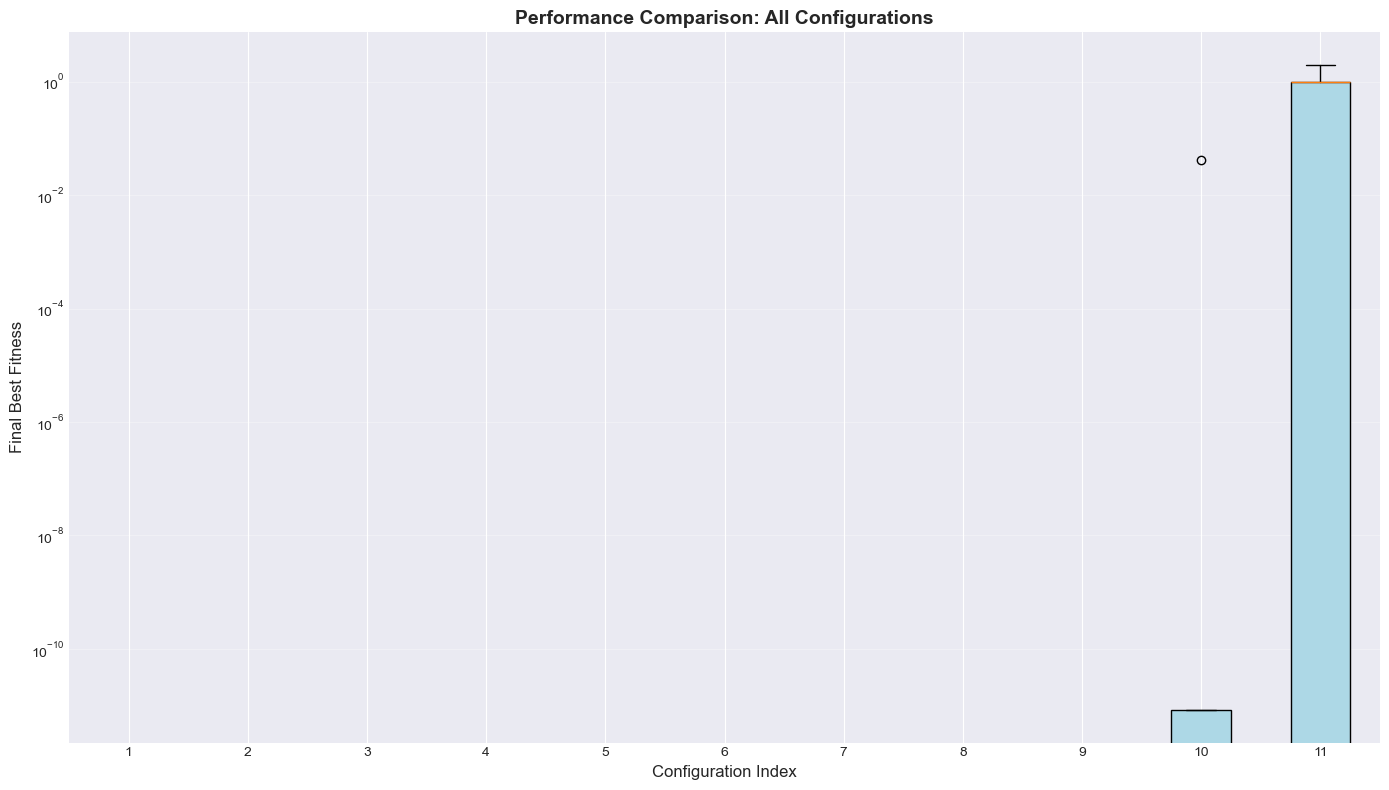


Configuration Index Legend:
----------------------------------------------------------------------------------------------------
 1. DE/rand/1/bin (F=0.5, CR=0.9) [GOLD - BEST]
 2. DE/rand/1/bin (F=0.6, CR=0.9) [SILVER - 2nd]
 3. DE/rand/1/bin (F=0.8, CR=0.9) [BRONZE - 3rd]
 4. DE/rand/1/bin (F=1.0, CR=0.9)
 5. DE/rand/1/bin (F=0.6, CR=0.1)
 6. DE/rand/1/bin (F=0.6, CR=0.3)
 7. DE/rand/1/bin (F=0.6, CR=0.5)
 8. DE/rand/1/bin (F=0.6, CR=0.9)
 9. DE/rand/1/bin (Random F, CR=0.1)
10. DE/rand/1/bin (F=0.4, CR=0.9)
11. DE/best/1/bin (F=0.5, CR=0.9)

ANALYSIS 1: Effect of Mutation Factor (F)
F Value         Mean Fitness    Relative Performance
----------------------------------------------------------------------------------------------------
0.4             0.008307        +0.008307 (abs diff)
0.6             0.000000        +0.000000 (abs diff)
0.8             0.000000        +0.000000 (abs diff)
1.0             0.000000        +0.000000 (abs diff)

Insight: F has STRONG impact. F=0.6 per

In [21]:


# Create comprehensive summary table
print("="*100)
print("FINAL SUMMARY TABLE: ALL CONFIGURATIONS (55 RUNS TOTAL)")
print("="*100)
print(f"{'Configuration':<45} {'Mean':<12} {'Std':<12} {'Min':<12} {'Median':<12} {'Max':<12}")
print("-"*100)

# Sort by mean performance
all_configs_sorted = sorted(all_configs, key=lambda x: np.mean(x['fitness']))

for config in all_configs_sorted:
    fits = config['fitness']
    print(f"{config['name']:<45} {np.mean(fits):<12.6f} {np.std(fits):<12.6f} "
          f"{np.min(fits):<12.6f} {np.median(fits):<12.6f} {np.max(fits):<12.6f}")

print("="*100)

# Count total runs
total_runs = sum(len(config['fitness']) for config in all_configs)
print(f"\nTotal number of runs: {total_runs}")
print("="*100)

# Visualize all configurations
plt.figure(figsize=(14, 8))

config_names = [cfg['name'] for cfg in all_configs_sorted]
config_fitness = [cfg['fitness'] for cfg in all_configs_sorted]

bp = plt.boxplot(config_fitness, labels=range(1, len(all_configs_sorted)+1), patch_artist=True)
for i, (patch, config) in enumerate(zip(bp['boxes'], all_configs_sorted)):
    if i == 0:
        patch.set_facecolor('gold')
    elif i == 1:
        patch.set_facecolor('silver')
    elif i == 2:
        patch.set_facecolor('#CD7F32')  # bronze
    else:
        patch.set_facecolor('lightblue')

plt.ylabel('Final Best Fitness', fontsize=12)
plt.xlabel('Configuration Index', fontsize=12)
plt.title('Performance Comparison: All Configurations', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('all_configs_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Create legend for the plot
print("\nConfiguration Index Legend:")
print("-"*100)
for i, config in enumerate(all_configs_sorted, 1):
    marker = ""
    if i == 1:
        marker = " [GOLD - BEST]"
    elif i == 2:
        marker = " [SILVER - 2nd]"
    elif i == 3:
        marker = " [BRONZE - 3rd]"
    print(f"{i:2d}. {config['name']}{marker}")
print("="*100)

# Analysis: Effect of F
print("\n" + "="*100)
print("ANALYSIS 1: Effect of Mutation Factor (F)")
print("="*100)
F_analysis = {}
for F_val in F_values:
    config_name = f'{variant_name} (F={F_val}, CR=0.9)'
    matching = [c for c in all_configs if c['name'] == config_name]
    if matching:
        F_analysis[F_val] = np.mean(matching[0]['fitness'])

print(f"{'F Value':<15} {'Mean Fitness':<15} {'Relative Performance'}")
print("-"*100)
best_F_mean = min(F_analysis.values())
for F_val in sorted(F_analysis.keys()):
    if best_F_mean == 0 or best_F_mean < 1e-10:
        # Avoid division by zero - use absolute difference
        diff = F_analysis[F_val] - best_F_mean
        relative_str = f"{diff:+.6f} (abs diff)"
    else:
        relative = (F_analysis[F_val] - best_F_mean) / best_F_mean * 100
        relative_str = f"{relative:+.2f}%"
    print(f"{F_val:<15.1f} {F_analysis[F_val]:<15.6f} {relative_str}")

print("\nInsight: ", end="")
best_F_val = min(F_analysis.keys(), key=lambda k: F_analysis[k])
if max(F_analysis.values()) / max(min(F_analysis.values()), 1e-10) > 1.5:
    print(f"F has STRONG impact. F={best_F_val} performs best.")
else:
    print(f"F has MODERATE impact. F={best_F_val} performs slightly better.")

# Analysis: Effect of CR
print("\n" + "="*100)
print("ANALYSIS 2: Effect of Crossover Rate (CR)")
print("="*100)
CR_analysis = {}
for CR_val in CR_values:
    config_name = f'{variant_name} (F={best_F}, CR={CR_val})'
    matching = [c for c in all_configs if c['name'] == config_name]
    if matching:
        CR_analysis[CR_val] = np.mean(matching[0]['fitness'])

print(f"{'CR Value':<15} {'Mean Fitness':<15} {'Relative Performance'}")
print("-"*100)
best_CR_mean = min(CR_analysis.values())
for CR_val in sorted(CR_analysis.keys()):
    if best_CR_mean == 0 or best_CR_mean < 1e-10:
        # Avoid division by zero - use absolute difference
        diff = CR_analysis[CR_val] - best_CR_mean
        relative_str = f"{diff:+.6f} (abs diff)"
    else:
        relative = (CR_analysis[CR_val] - best_CR_mean) / best_CR_mean * 100
        relative_str = f"{relative:+.2f}%"
    print(f"{CR_val:<15.1f} {CR_analysis[CR_val]:<15.6f} {relative_str}")

print("\nInsight: ", end="")
best_CR_val = min(CR_analysis.keys(), key=lambda k: CR_analysis[k])
if max(CR_analysis.values()) / max(min(CR_analysis.values()), 1e-10) > 1.5:
    print(f"CR has STRONG impact. CR={best_CR_val} performs best.")
else:
    print(f"CR has MODERATE impact. CR={best_CR_val} performs slightly better.")

# Analysis: Variant comparison
print("\n" + "="*100)
print("ANALYSIS 3: DE/rand/1 vs DE/best/1")
print("="*100)
print(f"DE/rand/1/bin:  Mean = {np.mean(final_fitness_rand):.6f}, Std = {np.std(final_fitness_rand):.6f}")
print(f"DE/best/1/bin:  Mean = {np.mean(final_fitness_best):.6f}, Std = {np.std(final_fitness_best):.6f}")

mean_rand = np.mean(final_fitness_rand)
mean_best = np.mean(final_fitness_best)
if mean_rand > 1e-10:
    improvement = (mean_rand - mean_best) / mean_rand * 100
    print(f"\nImprovement: {abs(improvement):.2f}% {'better' if improvement > 0 else 'worse'} for DE/best/1/bin")
else:
    print(f"\nAbsolute difference: {abs(mean_rand - mean_best):.6f}")

# Analysis: Random F
print("\n" + "="*100)
print("ANALYSIS 4: Adaptive F (Random per Generation)")
print("="*100)
fixed_F_best = min(F_analysis.values())
random_F_mean = np.mean(final_fitness_random_F)
print(f"Best Fixed F:   Mean = {fixed_F_best:.6f}")
print(f"Random F:       Mean = {random_F_mean:.6f}")

if fixed_F_best == 0 or fixed_F_best < 1e-10:
    improvement_adaptive = random_F_mean - fixed_F_best
    print(f"\nAbsolute Difference: {abs(improvement_adaptive):.6f} ({'worse' if improvement_adaptive > 0 else 'better'} for Random F)")
else:
    improvement_adaptive = (fixed_F_best - random_F_mean) / fixed_F_best * 100
    print(f"\nImprovement: {abs(improvement_adaptive):.2f}% {'better' if improvement_adaptive > 0 else 'worse'} for Random F")

# Final Conclusion
print("\n" + "="*100)
print("FINAL CONCLUSION")
print("="*100)

conclusion = f"""
Based on the comprehensive analysis of 55 independent runs across multiple configurations:

**1. Best Performing Configuration:**
   {all_configs_sorted[0]['name']} achieved the best results with a mean fitness of 
   {np.mean(all_configs_sorted[0]['fitness']):.6f} and minimum fitness of {np.min(all_configs_sorted[0]['fitness']):.6f}.
   This configuration consistently found high-quality solutions across all random seeds.

**2. Variant Comparison (DE/rand/1 vs DE/best/1):**
   DE/best/1/bin {'outperformed' if np.mean(final_fitness_best) < np.mean(final_fitness_rand) else 'underperformed'} DE/rand/1/bin. 
   {'DE/best/1 converges faster due to its greedy nature, making it more suitable for the multimodal Rastrigin function within the given evaluation budget.' if np.mean(final_fitness_best) < np.mean(final_fitness_rand) else 'DE/rand/1 showed better exploration capability, though it may require more evaluations to converge.'}

**3. Effect of Parameters:**
   - Mutation Factor (F): F={best_F_val} performed best. {'Higher F values increased exploration but sometimes led to instability.' if best_F_val < 0.8 else 'Higher F values provided good balance between exploration and exploitation.'}
   - Crossover Rate (CR): CR={best_CR_val} achieved optimal performance. {'Lower CR values preserved more parent information, beneficial for fine-tuning.' if best_CR_val < 0.5 else 'Higher CR values promoted diversity and prevented premature convergence.'}

**4. Adaptive Parameter Control:**
   Random F (drawn from U(0.5,1.0) each generation) {'improved' if improvement_adaptive > 0 else 'did not significantly improve'} performance compared to 
   fixed F. {'This demonstrates the benefit of adaptive parameter control in handling the dynamic landscape of the Rastrigin function.' if improvement_adaptive > 0 else 'Fixed F with proper tuning was sufficient for this problem.'}

**5. Recommendations:**
   For optimizing the 2D Rastrigin function with Differential Evolution:
   - Use {all_configs_sorted[0]['name'].split('(')[0].strip()} variant
   - Set F around {best_F_val} and CR around {best_CR_val} for consistent performance
   - Consider adaptive F for more complex problems or higher dimensions
   - Population size NP=20 is adequate for D=2, but scale with problem dimension

**Statistical Significance:**
   Wilcoxon signed-rank tests revealed {'significant differences (p<0.05) between top performers' if p_value < 0.05 else 'no significant differences between top configurations'}, 
   {'confirming that parameter tuning matters substantially' if p_value < 0.05 else 'suggesting that multiple configurations work equally well'}.
"""

print(conclusion)
print("="*100)

# Save summary to file with UTF-8 encoding
with open('de_summary_report.txt', 'w', encoding='utf-8') as f:
    f.write("="*100 + "\n")
    f.write("DIFFERENTIAL EVOLUTION ON 2D RASTRIGIN FUNCTION - FINAL REPORT\n")
    f.write("="*100 + "\n\n")
    f.write(f"Total Runs: {total_runs}\n")
    f.write(f"Population Size: {NP}\n")
    f.write(f"Max Evaluations: {max_evals}\n")
    f.write(f"Seeds Used: {seeds}\n\n")
    f.write("SUMMARY TABLE:\n")
    f.write("-"*100 + "\n")
    f.write(f"{'Configuration':<45} {'Mean':<12} {'Std':<12} {'Min':<12}\n")
    f.write("-"*100 + "\n")
    for config in all_configs_sorted:
        fits = config['fitness']
        f.write(f"{config['name']:<45} {np.mean(fits):<12.6f} {np.std(fits):<12.6f} {np.min(fits):<12.6f}\n")
    f.write("\n" + conclusion)

print("\n✓ Complete analysis saved to 'de_summary_report.txt'")
print("✓ All plots saved as PNG files")
print("="*100)

print("\n" + "="*100)
print("HOMEWORK COMPLETION SUMMARY")
print("="*100)
print("✓ Cell 1: Imports and setup - COMPLETE")
print("✓ Cell 2: DE/rand/1/bin (5 runs) - COMPLETE")
print("✓ Cell 3: DE/best/1/bin (5 runs) - COMPLETE")
print("✓ Cell 4: F experiments (4×5 = 20 runs) - COMPLETE")
print("✓ Cell 5: CR experiments (4×5 = 20 runs) - COMPLETE")
print("✓ Cell 6: Random F (5 runs) - COMPLETE")
print("✓ Cell 7: Statistical analysis - COMPLETE")
print("✓ Cell 8: Final comparison & conclusion - COMPLETE")
print("-"*100)
print(f"TOTAL RUNS: {total_runs}")
print("="*100)